In [1]:
import pandas as pd
import numpy as np
import copernicusmarine as cm
import xgboost as xgb
import matplotlib.pyplot as plt

# XGboost with more features

Goal of this notebook is to do more modelling by incorporating extra datasets.

In [4]:
bathymetry_dataset_id = "cmems_mod_glo_phy_my_0.083deg_static"
carbon_dataset_id = "dataset-carbon-rep-monthly"
salinity_dataset_id = "cmems_obs-mob_glo_phy-sss_my_multi_P1M"
oxygen_dataset_id = 'cmems_mod_glo_bgc-bio_anfc_0.25deg_P1M-m'
chlorophyl_dataset_id = 'cmems_mod_glo_bgc-pft_anfc_0.25deg_P1M-m'
chemicals_dataset_id = 'cmems_mod_glo_bgc-nut_anfc_0.25deg_P1M-m'
chl_color_dataset = "cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M"

Lots of extra datasets to choose from - I will incorporate data from the carbon dataset.

In [24]:
chlorophyl_df = cm.read_dataframe(
    dataset_id = chlorophyl_dataset_id,
    start_datetime= start_date,
    end_datetime = end_date
)

carbon_df = cm.read_dataframe(
    dataset_id = carbon_dataset_id,
    start_datetime= start_date,
    end_datetime = end_date,
    variables = ["fgco2","omega_ar","omega_ca","ph","spco2","talk","tco2"]
)

INFO - 2024-08-11T17:28:27Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-11T17:28:27Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-11T17:28:30Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-08-11T17:29:43Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-11T17:29:43Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-11T17:29:45Z - Service was not specified, the default one was selected: "arco-geo-series"


In [135]:
chem_df = cm.read_dataframe(
    dataset_id = chemicals_dataset_id,
    start_datetime= start_date,
    end_datetime = end_date
)

INFO - 2024-08-11T19:37:53Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-11T19:37:53Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-11T19:37:57Z - Service was not specified, the default one was selected: "arco-geo-series"


In [26]:
chlorophyl_df.to_pickle('chl-10-21-glob.pk')
carbon_df.to_pickle('carbon-10-21-glob.pk')
chem_df.to_pickle('chem-10-21-glob.pk')

In [2]:
chem_df = pd.read_pickle('chem-10-21-glob.pk')
chlorophyl_df = pd.read_pickle('chl-10-21-glob.pk')


In [3]:
chem_df.reset_index(inplace=True)
chlorophyl_df.reset_index(inplace=True)

The carbon dataframe does not have depth - to merge PISCES data with carbon data, will only use PISCES data closest to the surface.

In [4]:
chem_shallow_df = chem_df.loc[chem_df.depth<1].copy()
chlor_shallow_df = chlorophyl_df.loc[chlorophyl_df.depth<1].copy()

In [5]:
chem_shallow_df['chl'] = chlor_shallow_df.chl
chem_shallow_df['phyc'] = chlor_shallow_df.phyc

In [13]:
chem_shallow_df

,depth,latitude,longitude,time,fe,no3,po4,si,chl,phyc,x,y
0,0.494025,-80.0,-180.00,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,-800,800
1,0.494025,-80.0,-179.75,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,-798,800
2,0.494025,-80.0,-179.50,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,-796,800
3,0.494025,-80.0,-179.25,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,-794,800
4,0.494025,-80.0,-179.00,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,-792,800
...,...,...,...,...,...,...,...,...,...,...,...,...
980635,0.494025,90.0,178.75,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,2070,2160
980636,0.494025,90.0,179.00,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,2072,2160
980637,0.494025,90.0,179.25,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,2074,2160
980638,0.494025,90.0,179.50,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,2076,2160


## Merging datasets 

I'm going to start by replacing longitude and latitude with integers

In [14]:
def long_to_x(long):
    return int(8*(long+180))

def lat_to_y(lat):
    return int(8*(lat+80))


def x_to_long(x):
    return (x/8)-180

def y_to_lat(y):
    return (y/8)-80

In [15]:
chem_shallow_df['x'] = chem_shallow_df.longitude.apply(long_to_x)
chem_shallow_df['y'] = chem_shallow_df.latitude.apply(lat_to_y)

In [51]:
chem_shallow_df[['x','y' ,'fe', 'no3', 'po4', 'si',
       'chl', 'phyc']].values[0][2:]

array([nan, nan, nan, nan, nan, nan])

All of the data we will use is going into a dictionary - this is going to speed up the merging process.

Once the data has moved from dataframe to dictionary we compute averages to obtain extra datapoints.

In [52]:
chem_dict = {}
for r in list(chem_shallow_df[['x','y' ,'fe', 'no3', 'po4', 'si',
       'chl', 'phyc']].values):
    chem_dict[(int(r[0]),int(r[1]))] = r[2:]


chem_xmax = int(chem_shallow_df.x.max())
chem_ymax = int(chem_shallow_df.y.max())

# Creating new datapoints
for i in range(0,chem_xmax-2,2):
    for j in range(0,chem_ymax,2):
        tups = [(i,j),(i+2,j),(i,j+2),(i+2,j+2)]
        chem_dict[(i+1,j+1)] = sum([chem_dict[tup] for tup in tups])/4

# Dropping points without data
chem_tups_with_data = []
for t in chem_dict:
    v = chem_dict[t]
    mv = np.mean(v)
    if mv == mv:
        chem_tups_with_data.append(t)

In [24]:
carbon_df = pd.read_pickle('carbon-10-21-glob.pk')

In [27]:
carbon_df.reset_index(inplace=True)
# The PISCES data does not have data between -90 and -80 latitude so we drop
# those from carbon data
carbon_df = carbon_df.loc[carbon_df.latitude>=-80].copy()

In [30]:
carbon_df['x'] = carbon_df.longitude.apply(long_to_x)
carbon_df['y'] = carbon_df.latitude.apply(lat_to_y)

In [54]:
carbon_df[['x','y','fgco2', 'omega_ar', 'omega_ca', 'ph',
       'spco2', 'talk', 'tco2']]

carb_dict = {}
for r in carbon_df[['x','y','fgco2', 'omega_ar', 'omega_ca', 'ph',
       'spco2', 'talk', 'tco2']].values:
    carb_dict[(int(r[0]),int(r[1]))] = r[2:]


carb_xmax = int(carbon_df.x.max())
carb_ymax = int(carbon_df.y.max())

for i in range(1,carb_xmax-2,2):
    for j in range(1,carb_ymax-2,2):
        tups = [(i,j),(i+2,j),(i,j+2),(i+2,j+2)]
        mean_tups = (i+1,j+1)
        carb_dict[(i+1,j+1)] = sum([carb_dict[tup] for tup in tups])/4

carb_tups_w_data = []
for t in carb_dict:
    v = carb_dict[t]
    mv = np.mean(v)
    if mv == mv:
        carb_tups_w_data.append(t)

We are now ready to merge. We find the points where we have data from both datasets and collect the features we need from each dataset.

In [57]:
tups_both = list(set(carb_tups_w_data).intersection(set(chem_tups_with_data)))

In [36]:
carbon_feats = ['fgco2', 'omega_ar', 'omega_ca', 'ph','spco2', 'talk', 'tco2']
chem_feats = ['fe', 'no3', 'po4', 'si','chl', 'phyc']

We combine everything into a single dataframe

In [44]:
merged_data = {'x':[],'y':[]}
for f in carbon_feats:
    merged_data[f]=[]
for f in chem_feats:
    merged_data[f]=[]

for xy in tups_both:
    merged_data['x'].append(xy[0])
    merged_data['y'].append(xy[1])
    carb_vec = carb_dict[xy]
    for i,f in enumerate(carbon_feats):
        merged_data[f].append(carb_vec[i])
    for i,f in enumerate(chem_feats):
        merged_data[f].append(chem_dict[xy][i])

merged_df = pd.DataFrame(merged_data)

We bring back the old coordinates and then keep only the columns we will be using.

In [60]:
merged_df['latitude'] = merged_df.y.apply(y_to_lat)
merged_df['longitude'] = merged_df.x.apply(x_to_long)

merged_df = merged_df[[ 'latitude', 'longitude','fgco2', 'omega_ar', 'omega_ca', 'ph', 'spco2', 'talk',
       'tco2', 'fe', 'no3', 'po4', 'si', 'chl', 'phyc']]

In [86]:
merged_features = ['latitude', 'longitude','fgco2', 'omega_ar', 'omega_ca', 'ph', 'spco2', 'talk',
       'tco2', 'fe', 'no3', 'po4', 'si']

In [80]:
merged_df.to_pickle('carbon-pisces-merged.pk')

In [81]:
merged_df

,latitude,longitude,fgco2,omega_ar,omega_ca,ph,spco2,talk,tco2,fe,no3,po4,si,chl,phyc
0,-12.375,45.125,-0.110034,3.446306,5.199481,8.035338,409.610870,2292.652100,1987.368652,0.000061,0.000398,0.026926,0.499061,0.016176,0.218731
1,73.500,-8.250,5.931731,1.733141,2.757106,8.117337,325.349091,2282.134827,2126.286926,0.000059,1.323279,0.103620,0.587495,0.027842,0.096755
2,-38.625,171.125,2.691503,2.686699,4.178655,8.094999,358.161682,2323.055176,2075.048584,0.000014,0.006203,0.041830,0.299250,0.047489,0.301418
3,-36.125,38.625,3.318564,2.959258,4.579558,8.106160,348.271515,2337.646240,2064.160156,0.000020,0.077017,0.051725,0.318254,0.077063,0.333928
4,24.125,-81.875,-0.377263,3.957772,5.911628,8.037149,414.877625,2392.969727,2041.518555,0.000182,0.001371,0.000477,0.397475,0.029105,0.207790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153657,28.750,136.000,0.464342,3.492145,5.266522,8.045138,394.884834,2264.300476,1956.536285,0.000045,0.000950,0.004471,0.531683,0.014485,0.147185
1153658,54.875,-143.625,1.329782,1.715211,2.717761,8.041293,391.195190,2175.042480,2022.784058,0.000012,2.219215,0.224999,3.336908,0.043837,0.162506
1153659,2.875,-40.375,-0.384845,3.802696,5.692340,8.033709,416.504974,2355.795410,2020.633423,0.000045,0.000787,0.012432,0.274529,0.016103,0.214477
1153660,13.250,112.250,0.036770,3.473380,5.220406,8.033383,397.265816,2192.698975,1891.548767,0.000219,0.000761,0.006116,0.805375,0.024369,0.236246


## XGBoost

We can now run XGboost

In [89]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [83]:
Xy_train, Xy_test = train_test_split(merged_df,train_size = 0.2,shuffle = True, random_state = 1729)

MSE: 0.0004
RMSE: 0.0201
Feature Importances:
latitude: 0.06930579245090485
longitude: 0.03354866802692413
fgco2: 0.049353212118148804
omega_ar: 0.08728695660829544
omega_ca: 0.10462351888418198
ph: 0.017844492569565773
spco2: 0.054851558059453964
talk: 0.01717587560415268
tco2: 0.10386943817138672
fe: 0.10595817118883133
no3: 0.2815938889980316
po4: 0.029742838814854622
si: 0.04484561085700989


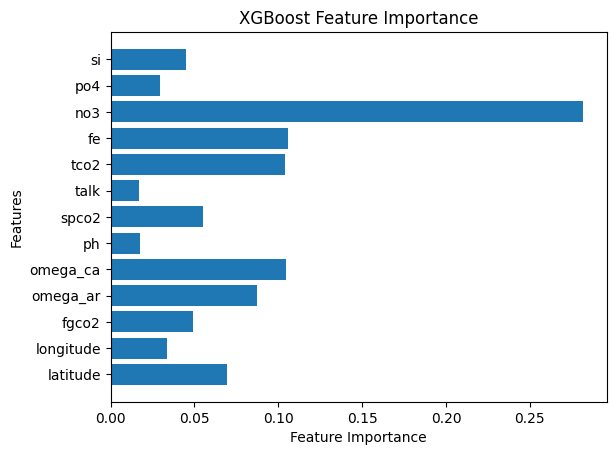

In [88]:
# Create an XGBoost classifier
model = xgb.XGBRegressor(
    max_depth=3,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1,# Minimum sum of instance weight needed in a child
)

# Train the model
model.fit(Xy_train[merged_features], Xy_train.chl)

# Make predictions on the test set
y_pred = model.predict(Xy_test[merged_features])

# Evaluate the model - using MSE since we're doing regression
mse = mean_squared_error(y_pred=y_pred,y_true = Xy_test.chl)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")

# Explore feature importance
feature_importances = model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(merged_features, feature_importances):
    print(f"{feature}: {importance}")

# Visualize feature importance
plt.barh(merged_features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()


## Grid search

In [92]:
model = xgb.XGBRegressor(
    max_depth=3,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1,# Minimum sum of instance weight needed in a child
)

param_grid = {
    'max_depth': [5, 7,10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200,400]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error'

)

# Fit the grid search to the training data
grid_search.fit(Xy_train[merged_features], Xy_train.chl)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new model with the best parameters
best_model = xgb.XGBRegressor(**best_params)

# Train the best model
best_model.fit(Xy_train[merged_features], Xy_train.chl)

# Make predictions on the test set
y_pred_best = best_model.predict(Xy_test[merged_features])

# Evaluate the best model
mse_best = mean_squared_error(y_pred=y_pred_best,y_true = Xy_test.chl)
print(f"MSE with Best Parameters: {mse_best:.5f}")
print(f"RMSE with Best Parameters: {np.sqrt(mse_best):.5f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400}
MSE with Best Parameters: 0.00004
RMSE with Best Parameters: 0.00615


The chlorophyll values are very small - a more intuitive metric is simple mean absolute error as a percentage of the true value.

In [96]:
np.mean(((y_pred_best-Xy_test.chl)/Xy_test.chl).apply(abs))

0.06161503903779127

On average our predictions are off by about 6 percent.

Can also check how often our predictions are within 1 standard deviation of the correct value.

In [117]:
Xy_train.chl.std()

0.03934364190177824

In [118]:
ct = 0
for i,c in enumerate(y_pred_best):
    ct+=int(abs(Xy_test.chl.values[i]-c)<0.03934364190177824)

Our results are almost always within one standard deviation of the correct value.

In [ ]:
proportion_within_one_std = ct/len(y_pred_best)
print(proportion_within_one_std)

## Shap

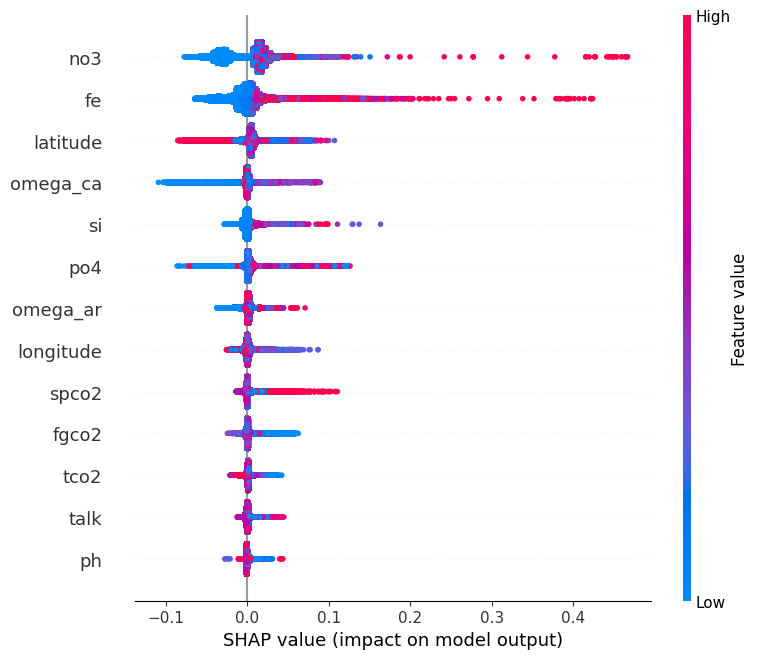

In [122]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(Xy_test[merged_features])

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], Xy_test[merged_features].iloc[0,:])

# Summarize the effects of all the features
shap.summary_plot(shap_values, Xy_test[merged_features])

## Next step: Adding salinity

In [97]:
salt_df = pd.read_pickle('salt-10-21-glob.pk')

In [99]:
salt_df.reset_index(inplace=True)

In [107]:
salt_df = salt_df[['latitude', 'longitude', 'dos','sos']].loc[salt_df.latitude>=-80].copy()

In [110]:
xys_salt = {(r[0],r[1]) for r in salt_df[['latitude', 'longitude']].values}
xys_merged = {(r[0],r[1]) for r in merged_df[['latitude', 'longitude']].values}

In [109]:
len(xys_salt)

3916800

In [111]:
len(xys_merged)

1153662

In [112]:
len(xys_salt.intersection(xys_merged))

0

There are no points in common - to figure out how to merge them we need to see what they look like.

In [114]:
merged_df

,latitude,longitude,fgco2,omega_ar,omega_ca,ph,spco2,talk,tco2,fe,no3,po4,si,chl,phyc
0,-12.375,45.125,-0.110034,3.446306,5.199481,8.035338,409.610870,2292.652100,1987.368652,0.000061,0.000398,0.026926,0.499061,0.016176,0.218731
1,73.500,-8.250,5.931731,1.733141,2.757106,8.117337,325.349091,2282.134827,2126.286926,0.000059,1.323279,0.103620,0.587495,0.027842,0.096755
2,-38.625,171.125,2.691503,2.686699,4.178655,8.094999,358.161682,2323.055176,2075.048584,0.000014,0.006203,0.041830,0.299250,0.047489,0.301418
3,-36.125,38.625,3.318564,2.959258,4.579558,8.106160,348.271515,2337.646240,2064.160156,0.000020,0.077017,0.051725,0.318254,0.077063,0.333928
4,24.125,-81.875,-0.377263,3.957772,5.911628,8.037149,414.877625,2392.969727,2041.518555,0.000182,0.001371,0.000477,0.397475,0.029105,0.207790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153657,28.750,136.000,0.464342,3.492145,5.266522,8.045138,394.884834,2264.300476,1956.536285,0.000045,0.000950,0.004471,0.531683,0.014485,0.147185
1153658,54.875,-143.625,1.329782,1.715211,2.717761,8.041293,391.195190,2175.042480,2022.784058,0.000012,2.219215,0.224999,3.336908,0.043837,0.162506
1153659,2.875,-40.375,-0.384845,3.802696,5.692340,8.033709,416.504974,2355.795410,2020.633423,0.000045,0.000787,0.012432,0.274529,0.016103,0.214477
1153660,13.250,112.250,0.036770,3.473380,5.220406,8.033383,397.265816,2192.698975,1891.548767,0.000219,0.000761,0.006116,0.805375,0.024369,0.236246


In [150]:
xys_salt_0 = {xy for xy in xys_salt if abs(xy[1]+105) <1 and abs(xy[0])<1}
xys_merg_0 = {xy for xy in xys_merged if abs(xy[1]+105) <1 and abs(xy[0])<1}

In [151]:
x_s_0 = []
y_s_0 = []
for xy in xys_salt_0:
    x_s_0.append(xy[0])
    y_s_0.append(xy[1])

x_c_0 = []
y_c_0 = []
for xy in xys_merg_0:
    x_c_0.append(xy[0])
    y_c_0.append(xy[1])

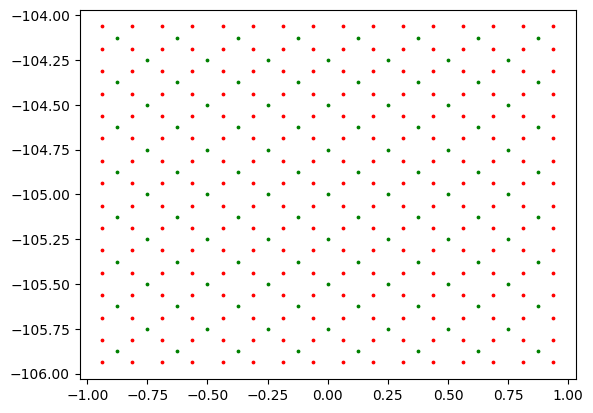

In [155]:
plt.scatter(x=x_s_0,y=y_s_0,c='r',s=3)
plt.scatter(x=x_c_0,y=y_c_0,c='g',s=3)

The first two datasets essentially had the same resolution, but were shifted.

Here, the salinity data has a finer resolution and the points are shifted.